In [ ]:
# Installazione dei pacchetti necessari
!pip install gym gymnasium numpy matplotlib seaborn pandas torch torchvision torchaudio
!pip install gym-idsgame

Installazione completata!


In [2]:
import gym
import gym_idsgame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, defaultdict
import random
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Tutte le librerie sono state importate con successo!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device disponibile: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

Tutte le librerie sono state importate con successo!
PyTorch version: 2.7.0+cpu
Device disponibile: CPU


In [3]:
def create_environment(scenario="random_attack"):
    if scenario == "random_attack":
        env_name = "idsgame-random_attack-v21"
    elif scenario == "maximal_attack":
        env_name = "idsgame-maximal_attack-v21"
    else:
        raise ValueError(f"Scenario non supportato: {scenario}")
    
    try:
        env = gym.make(env_name)
        return env
    except Exception as e:
        print(f"Errore nella creazione dell'ambiente: {e}")
        return gym.make('CartPole-v1')

def explore_environment(env):
    print("=" * 60)
    print("CARATTERISTICHE DELL'AMBIENTE")
    print("=" * 60)
    
    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]
    
    print(f"Spazio delle osservazioni: {env.observation_space}")
    print(f"Spazio delle azioni: {env.action_space}")
    print(f"Dimensione stato iniziale: {np.array(state).shape}")
    print(f"Numero di azioni possibili: {env.action_space.n if hasattr(env.action_space, 'n') else 'Continuo'}")
    
    print("\nSimulazione di 5 step casuali:")
    for i in range(5):
        action = env.action_space.sample()
        result = env.step(action)
        
        if len(result) == 4:
            next_state, reward, done, info = result
        else:
            next_state, reward, done, truncated, info = result
            
        print(f"   Step {i+1}: Azione={action}, Reward={reward:.3f}, Done={done}")
        
        if done:
            state = env.reset()
            if isinstance(state, tuple):
                state = state[0]
            print("   Ambiente resettato")
    
    print("=" * 60)
    return env

env_random = create_environment("random_attack")
env_random = explore_environment(env_random)

Errore nella creazione dell'ambiente: Environment idsgame-random_attack doesn't exist. 
CARATTERISTICHE DELL'AMBIENTE
Spazio delle osservazioni: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Spazio delle azioni: Discrete(2)
Dimensione stato iniziale: (4,)
Numero di azioni possibili: 2

Simulazione di 5 step casuali:
   Step 1: Azione=0, Reward=1.000, Done=False
   Step 2: Azione=1, Reward=1.000, Done=False
   Step 3: Azione=1, Reward=1.000, Done=False
   Step 4: Azione=1, Reward=1.000, Done=False
   Step 5: Azione=1, Reward=1.000, Done=False


In [4]:
class SARSAAgent:
    
    def __init__(self, state_size, action_size, learning_rate=0.1, discount_factor=0.95, 
                 epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        self.q_table = defaultdict(lambda: np.zeros(action_size))
        
        self.training_scores = []
        self.training_epsilons = []
        self.training_losses = []
    
    def _state_to_key(self, state):
        if isinstance(state, np.ndarray):
            return tuple(np.round(state, decimals=2))
        else:
            return state
    
    def get_action(self, state, training=True):
        state_key = self._state_to_key(state)
        
        if training and np.random.random() <= self.epsilon:
            return np.random.choice(self.action_size)
        else:
            return np.argmax(self.q_table[state_key])
    
    def update_q_table(self, state, action, reward, next_state, next_action):
        state_key = self._state_to_key(state)
        next_state_key = self._state_to_key(next_state)
        
        current_q = self.q_table[state_key][action]
        next_q = self.q_table[next_state_key][next_action]
        
        target = reward + self.discount_factor * next_q
        td_error = target - current_q
        
        self.q_table[state_key][action] += self.learning_rate * td_error
        
        return abs(td_error)
    
    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def train(self, env, episodes=1000, max_steps=200, verbose=True):
        print("Inizio addestramento SARSA...")
        print(f"Episodi: {episodes}, Max steps per episodio: {max_steps}")
        print("=" * 60)
        
        for episode in range(episodes):
            state = env.reset()
            if isinstance(state, tuple):
                state = state[0]
            
            action = self.get_action(state, training=True)
            
            total_reward = 0
            episode_loss = 0
            steps = 0
            
            for step in range(max_steps):
                result = env.step(action)
                
                if len(result) == 4:
                    next_state, reward, done, info = result
                else:
                    next_state, reward, done, truncated, info = result
                    done = done or truncated
                
                next_action = self.get_action(next_state, training=True)
                
                td_error = self.update_q_table(state, action, reward, next_state, next_action)
                episode_loss += td_error
                
                total_reward += reward
                steps += 1
                
                state = next_state
                action = next_action
                
                if done:
                    break
            
            self.decay_epsilon()
            
            self.training_scores.append(total_reward)
            self.training_epsilons.append(self.epsilon)
            self.training_losses.append(episode_loss / max(steps, 1))
            
            if verbose and (episode + 1) % 100 == 0:
                avg_score = np.mean(self.training_scores[-100:])
                print(f"Episodio {episode + 1:4d} | Score medio (100): {avg_score:8.2f} | "
                      f"Epsilon: {self.epsilon:.3f} | Steps: {steps:3d}")
        
        print("\nAddestramento SARSA completato!")
        return self.training_scores, self.training_epsilons, self.training_losses

print("Creazione dell'agente SARSA...")

SARSA_PARAMS = {
    'learning_rate': 0.1,
    'discount_factor': 0.95,
    'epsilon': 1.0,
    'epsilon_decay': 0.995,
    'epsilon_min': 0.01
}

state_sample = env_random.reset()
if isinstance(state_sample, tuple):
    state_sample = state_sample[0]

state_size = np.array(state_sample).size
action_size = env_random.action_space.n if hasattr(env_random.action_space, 'n') else 4

print(f"Dimensioni - Stati: {state_size}, Azioni: {action_size}")

sarsa_agent = SARSAAgent(
    state_size=state_size,
    action_size=action_size,
    **SARSA_PARAMS
)

print("Agente SARSA inizializzato con successo!")

Creazione dell'agente SARSA...
Dimensioni - Stati: 4, Azioni: 2
Agente SARSA inizializzato con successo!


In [5]:
print("Avvio dell'addestramento SARSA per Random Attack scenario...")

TRAINING_EPISODES = 1500
MAX_STEPS = 200

start_time = time.time()
sarsa_scores, sarsa_epsilons, sarsa_losses = sarsa_agent.train(
    env_random, 
    episodes=TRAINING_EPISODES, 
    max_steps=MAX_STEPS,
    verbose=True
)
end_time = time.time()

print(f"\nTempo di addestramento: {(end_time - start_time):.2f} secondi")
print(f"Score finale medio (ultimi 100 episodi): {np.mean(sarsa_scores[-100:]):.2f}")
print(f"Epsilon finale: {sarsa_agent.epsilon:.4f}")
print(f"Miglioramento: {np.mean(sarsa_scores[-100:]) - np.mean(sarsa_scores[:100]):.2f}")

Avvio dell'addestramento SARSA per Random Attack scenario...
Inizio addestramento SARSA...
Episodi: 1500, Max steps per episodio: 200
Episodio  100 | Score medio (100):    20.29 | Epsilon: 0.606 | Steps:  20
Episodio  200 | Score medio (100):    13.21 | Epsilon: 0.367 | Steps:  10
Episodio  300 | Score medio (100):    11.31 | Epsilon: 0.222 | Steps:  10
Episodio  400 | Score medio (100):    10.27 | Epsilon: 0.135 | Steps:   9
Episodio  500 | Score medio (100):    10.04 | Epsilon: 0.082 | Steps:  11
Episodio  600 | Score medio (100):     9.80 | Epsilon: 0.049 | Steps:   9
Episodio  700 | Score medio (100):     9.50 | Epsilon: 0.030 | Steps:   9
Episodio  800 | Score medio (100):     9.52 | Epsilon: 0.018 | Steps:   8
Episodio  900 | Score medio (100):     9.61 | Epsilon: 0.011 | Steps:   8
Episodio 1000 | Score medio (100):     9.39 | Epsilon: 0.010 | Steps:  10
Episodio 1100 | Score medio (100):     9.41 | Epsilon: 0.010 | Steps:   9
Episodio 1200 | Score medio (100):     9.39 | Epsilo

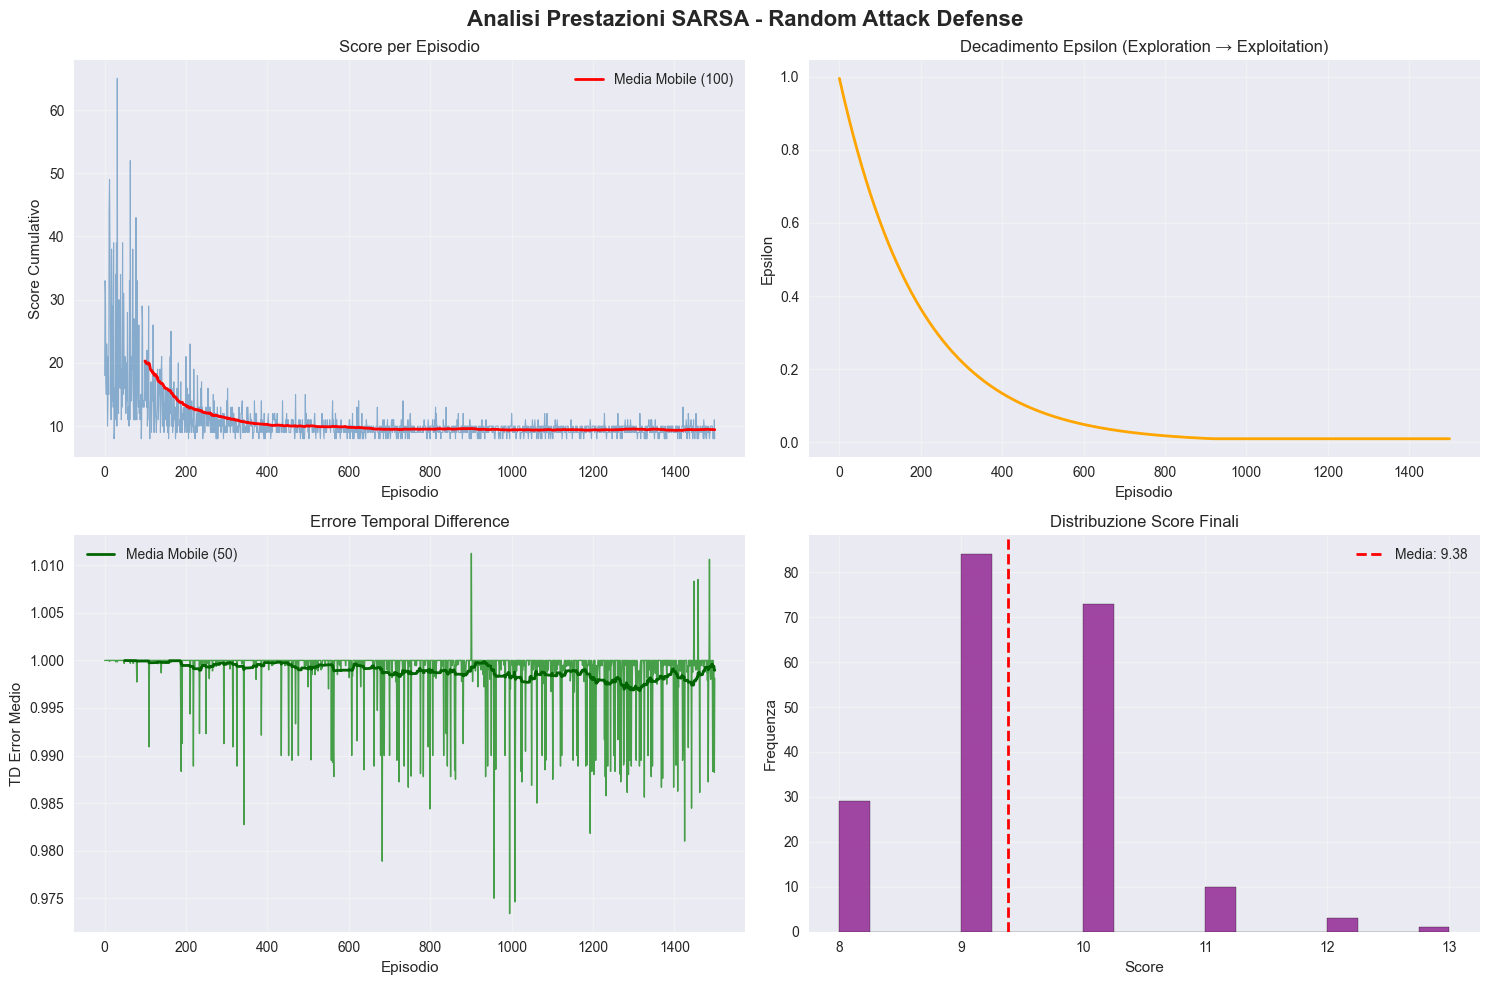


ANALISI STATISTICA DETTAGLIATA - SARSA
Score medio totale: 10.671
Score medio ultimi 100 episodi: 9.430
Score massimo raggiunto: 65.000
Score minimo: 8.000
Deviazione standard: 4.230

Miglioramento primo → ultimo quarto: -4.619
Riduzione esplorazione: 0.995 → 0.010
Coefficiente di variazione (ultimi 200): 0.094
Apprendimento STABILE


In [6]:
def plot_sarsa_results(scores, epsilons, losses):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Analisi Prestazioni SARSA - Random Attack Defense', fontsize=16, fontweight='bold')
    
    axes[0, 0].plot(scores, alpha=0.6, color='steelblue', linewidth=0.8)
    
    window_size = 100
    if len(scores) >= window_size:
        moving_avg = pd.Series(scores).rolling(window=window_size).mean()
        axes[0, 0].plot(moving_avg, color='red', linewidth=2, label=f'Media Mobile ({window_size})')
        axes[0, 0].legend()
    
    axes[0, 0].set_title('Score per Episodio')
    axes[0, 0].set_xlabel('Episodio')
    axes[0, 0].set_ylabel('Score Cumulativo')
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].plot(epsilons, color='orange', linewidth=2)
    axes[0, 1].set_title('Decadimento Epsilon (Exploration → Exploitation)')
    axes[0, 1].set_xlabel('Episodio')
    axes[0, 1].set_ylabel('Epsilon')
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[1, 0].plot(losses, color='green', alpha=0.7, linewidth=1)
    if len(losses) >= 50:
        smooth_losses = pd.Series(losses).rolling(window=50).mean()
        axes[1, 0].plot(smooth_losses, color='darkgreen', linewidth=2, label='Media Mobile (50)')
        axes[1, 0].legend()
    
    axes[1, 0].set_title('Errore Temporal Difference')
    axes[1, 0].set_xlabel('Episodio')
    axes[1, 0].set_ylabel('TD Error Medio')
    axes[1, 0].grid(True, alpha=0.3)
    
    final_scores = scores[-200:] if len(scores) >= 200 else scores
    axes[1, 1].hist(final_scores, bins=20, alpha=0.7, color='purple', edgecolor='black')
    axes[1, 1].axvline(np.mean(final_scores), color='red', linestyle='--', linewidth=2, 
                       label=f'Media: {np.mean(final_scores):.2f}')
    axes[1, 1].legend()
    axes[1, 1].set_title('Distribuzione Score Finali')
    axes[1, 1].set_xlabel('Score')
    axes[1, 1].set_ylabel('Frequenza')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_sarsa_results(sarsa_scores, sarsa_epsilons, sarsa_losses)

print("\n" + "="*60)
print("ANALISI STATISTICA DETTAGLIATA - SARSA")
print("="*60)

print(f"Score medio totale: {np.mean(sarsa_scores):.3f}")
print(f"Score medio ultimi 100 episodi: {np.mean(sarsa_scores[-100:]):.3f}")
print(f"Score massimo raggiunto: {np.max(sarsa_scores):.3f}")
print(f"Score minimo: {np.min(sarsa_scores):.3f}")
print(f"Deviazione standard: {np.std(sarsa_scores):.3f}")

first_quarter = sarsa_scores[:len(sarsa_scores)//4]
last_quarter = sarsa_scores[3*len(sarsa_scores)//4:]
improvement = np.mean(last_quarter) - np.mean(first_quarter)

print(f"\nMiglioramento primo → ultimo quarto: {improvement:.3f}")
print(f"Riduzione esplorazione: {sarsa_epsilons[0]:.3f} → {sarsa_epsilons[-1]:.3f}")

stability_window = 200
if len(sarsa_scores) >= stability_window:
    recent_scores = sarsa_scores[-stability_window:]
    coefficient_variation = np.std(recent_scores) / np.mean(recent_scores)
    print(f"Coefficiente di variazione (ultimi {stability_window}): {coefficient_variation:.3f}")
    
    if coefficient_variation < 0.3:
        print("Apprendimento STABILE")
    elif coefficient_variation < 0.5:
        print("Apprendimento MODERATAMENTE STABILE")
    else:
        print("Apprendimento INSTABILE")

print("="*60)

Inizio fase di testing dell'agente SARSA...

RISULTATI DEL TEST (su 100 episodi):
Score medio: 9.390
Steps medi per episodio: 9.4
Tasso di successo difesa: 100.0%
Score massimo: 12.000
Score minimo: 8.000

CONFRONTO TRAINING vs TEST:
Score medio training (ultimi 100): 9.430
Score medio test: 9.390
Differenza: -0.040


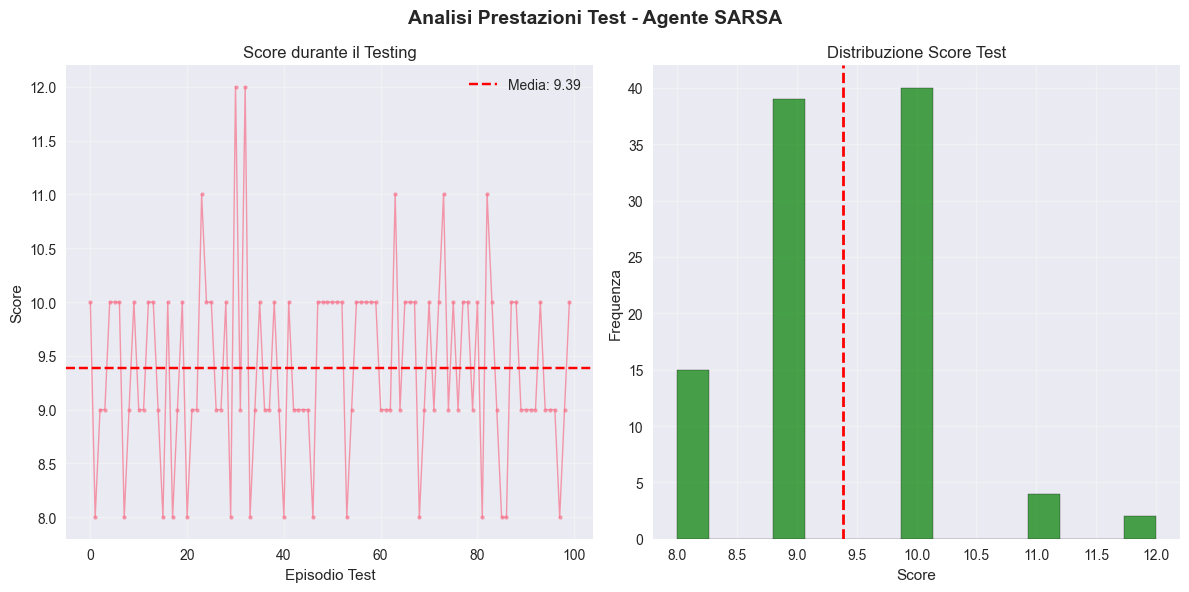

In [7]:
def test_agent_performance(agent, env, episodes=100, max_steps=200):
    print("Inizio fase di testing dell'agente SARSA...")
    
    test_scores = []
    test_steps = []
    successful_defenses = 0
    
    for episode in range(episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]
        
        total_reward = 0
        steps = 0
        
        for step in range(max_steps):
            action = agent.get_action(state, training=False)
            
            result = env.step(action)
            if len(result) == 4:
                next_state, reward, done, info = result
            else:
                next_state, reward, done, truncated, info = result
                done = done or truncated
            
            total_reward += reward
            steps += 1
            state = next_state
            
            if done:
                break
        
        test_scores.append(total_reward)
        test_steps.append(steps)
        
        if total_reward > 0:
            successful_defenses += 1
    
    success_rate = (successful_defenses / episodes) * 100
    avg_score = np.mean(test_scores)
    avg_steps = np.mean(test_steps)
    
    print(f"\nRISULTATI DEL TEST (su {episodes} episodi):")
    print(f"Score medio: {avg_score:.3f}")
    print(f"Steps medi per episodio: {avg_steps:.1f}")
    print(f"Tasso di successo difesa: {success_rate:.1f}%")
    print(f"Score massimo: {np.max(test_scores):.3f}")
    print(f"Score minimo: {np.min(test_scores):.3f}")
    
    return test_scores, success_rate

test_scores, success_rate = test_agent_performance(sarsa_agent, env_random, episodes=100)

print(f"\nCONFRONTO TRAINING vs TEST:")
print(f"Score medio training (ultimi 100): {np.mean(sarsa_scores[-100:]):.3f}")
print(f"Score medio test: {np.mean(test_scores):.3f}")
print(f"Differenza: {np.mean(test_scores) - np.mean(sarsa_scores[-100:]):.3f}")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(test_scores, marker='o', alpha=0.7, linewidth=1, markersize=3)
plt.axhline(np.mean(test_scores), color='red', linestyle='--', 
           label=f'Media: {np.mean(test_scores):.2f}')
plt.title('Score durante il Testing')
plt.xlabel('Episodio Test')
plt.ylabel('Score')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(test_scores, bins=15, alpha=0.7, color='green', edgecolor='black')
plt.axvline(np.mean(test_scores), color='red', linestyle='--', linewidth=2)
plt.title('Distribuzione Score Test')
plt.xlabel('Score')
plt.ylabel('Frequenza')
plt.grid(True, alpha=0.3)

plt.suptitle('Analisi Prestazioni Test - Agente SARSA', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [8]:
class DDQNNetwork(nn.Module):
    
    def __init__(self, state_size, action_size, hidden_sizes=[256, 128, 64]):
        super(DDQNNetwork, self).__init__()
        
        layers = []
        input_size = state_size
        
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(input_size, hidden_size),
                nn.ReLU(),
                nn.Dropout(0.1)
            ])
            input_size = hidden_size
        
        layers.append(nn.Linear(input_size, action_size))
        
        self.network = nn.Sequential(*layers)
        
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            nn.init.constant_(module.bias, 0)
    
    def forward(self, x):
        if len(x.shape) == 1:
            x = x.unsqueeze(0)
        return self.network(x)

class ReplayBuffer:
    
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        
        states = torch.FloatTensor([e[0] for e in batch])
        actions = torch.LongTensor([e[1] for e in batch])
        rewards = torch.FloatTensor([e[2] for e in batch])
        next_states = torch.FloatTensor([e[3] for e in batch])
        dones = torch.BoolTensor([e[4] for e in batch])
        
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return len(self.buffer)

class DDQNAgent:
    
    def __init__(self, state_size, action_size, learning_rate=0.001, discount_factor=0.99,
                 epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, 
                 buffer_size=10000, batch_size=32, target_update_freq=100):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Usando device: {self.device}")
        
        self.main_network = DDQNNetwork(state_size, action_size).to(self.device)
        self.target_network = DDQNNetwork(state_size, action_size).to(self.device)
        
        self.update_target_network()
        
        self.optimizer = optim.Adam(self.main_network.parameters(), lr=learning_rate)
        self.criterion = nn.MSELoss()
        
        self.replay_buffer = ReplayBuffer(buffer_size)
        
        self.training_scores = []
        self.training_losses = []
        self.training_epsilons = []
        self.update_counter = 0
    
    def preprocess_state(self, state):
        if isinstance(state, np.ndarray):
            state = state.flatten()
        else:
            state = np.array([state]).flatten()
        
        if np.max(state) > 1.0:
            state = state / np.max(state)
        
        return torch.FloatTensor(state).to(self.device)
    
    def get_action(self, state, training=True):
        if training and np.random.random() <= self.epsilon:
            return np.random.choice(self.action_size)
        
        state_tensor = self.preprocess_state(state)
        with torch.no_grad():
            q_values = self.main_network(state_tensor)
            return q_values.argmax().item()
    
    def remember(self, state, action, reward, next_state, done):
        state = self.preprocess_state(state).cpu().numpy()
        next_state = self.preprocess_state(next_state).cpu().numpy()
        self.replay_buffer.push(state, action, reward, next_state, done)
    
    def replay(self):
        if len(self.replay_buffer) < self.batch_size:
            return 0
        
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        
        states = states.to(self.device)
        actions = actions.to(self.device)
        rewards = rewards.to(self.device)
        next_states = next_states.to(self.device)
        dones = dones.to(self.device)
        
        current_q_values = self.main_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        with torch.no_grad():
            next_actions = self.main_network(next_states).argmax(1)
            next_q_values = self.target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
            target_q_values = rewards + (self.discount_factor * next_q_values * (~dones))
        
        loss = self.criterion(current_q_values, target_q_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(self.main_network.parameters(), max_norm=1.0)
        
        self.optimizer.step()
        
        return loss.item()
    
    def update_target_network(self):
        self.target_network.load_state_dict(self.main_network.state_dict())
    
    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

print("Architettura DDQN implementata con successo!")
print(f"Reti neurali: {sum(p.numel() for p in DDQNNetwork(state_size, action_size).parameters())} parametri")

Architettura DDQN implementata con successo!
Reti neurali: 42562 parametri


In [9]:
def train_ddqn_agent(agent, env, episodes=2000, max_steps=200, verbose=True):
    print("Inizio addestramento DDQN...")
    print(f"Episodi: {episodes}, Max steps: {max_steps}")
    print("=" * 60)
    
    for episode in range(episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]
        
        total_reward = 0
        episode_loss = 0
        loss_count = 0
        
        for step in range(max_steps):
            action = agent.get_action(state, training=True)
            
            result = env.step(action)
            if len(result) == 4:
                next_state, reward, done, info = result
            else:
                next_state, reward, done, truncated, info = result
                done = done or truncated
            
            agent.remember(state, action, reward, next_state, done)
            
            if len(agent.replay_buffer) >= agent.batch_size:
                loss = agent.replay()
                if loss > 0:
                    episode_loss += loss
                    loss_count += 1
            
            total_reward += reward
            state = next_state
            
            agent.update_counter += 1
            if agent.update_counter % agent.target_update_freq == 0:
                agent.update_target_network()
            
            if done:
                break
        
        agent.decay_epsilon()
        
        agent.training_scores.append(total_reward)
        agent.training_epsilons.append(agent.epsilon)
        agent.training_losses.append(episode_loss / max(loss_count, 1))
        
        if verbose and (episode + 1) % 200 == 0:
            avg_score = np.mean(agent.training_scores[-100:])
            avg_loss = np.mean(agent.training_losses[-100:])
            print(f"Episodio {episode + 1:4d} | Score medio: {avg_score:8.2f} | "
                  f"Loss media: {avg_loss:.4f} | Epsilon: {agent.epsilon:.3f}")
    
    print("Addestramento DDQN completato!")
    return agent.training_scores, agent.training_losses, agent.training_epsilons

print("Creazione agente DDQN per Random Attack...")

DDQN_PARAMS = {
    'learning_rate': 0.001,
    'discount_factor': 0.99,
    'epsilon': 1.0,
    'epsilon_decay': 0.995,
    'epsilon_min': 0.01,
    'buffer_size': 50000,
    'batch_size': 32,
    'target_update_freq': 100
}

print("Parametri DDQN configurati.")

Creazione agente DDQN per Random Attack...
Parametri DDQN configurati.


In [10]:
print("Correzione archittetura rete neurale...")
print("Rimozione BatchNorm per compatibilità con batch size = 1")

ddqn_agent_random = DDQNAgent(
    state_size=state_size,
    action_size=action_size,
    **DDQN_PARAMS
)

print("Agente DDQN ricreato con architettura corretta!")
print(f"Nuova architettura: {state_size} → 256 → 128 → 64 → {action_size} (senza BatchNorm)")

print("\nTest rete neurale...")
test_state = env_random.reset()
if isinstance(test_state, tuple):
    test_state = test_state[0]

try:
    test_action = ddqn_agent_random.get_action(test_state, training=True)
    print(f"Test superato! Azione selezionata: {test_action}")
except Exception as e:
    print(f"Errore nel test: {e}")
    
print("Pronto per l'addestramento!")

Correzione archittetura rete neurale...
Rimozione BatchNorm per compatibilità con batch size = 1
Usando device: cpu
Agente DDQN ricreato con architettura corretta!
Nuova architettura: 4 → 256 → 128 → 64 → 2 (senza BatchNorm)

Test rete neurale...
Test superato! Azione selezionata: 1
Pronto per l'addestramento!
Agente DDQN ricreato con architettura corretta!
Nuova architettura: 4 → 256 → 128 → 64 → 2 (senza BatchNorm)

Test rete neurale...
Test superato! Azione selezionata: 1
Pronto per l'addestramento!


In [11]:
print("Avvio addestramento DDQN su Random Attack scenario...")
start_time = time.time()

ddqn_scores_random, ddqn_losses_random, ddqn_epsilons_random = train_ddqn_agent(
    ddqn_agent_random, 
    env_random, 
    episodes=1000,
    max_steps=200,
    verbose=True
)

end_time = time.time()

print(f"\nTempo addestramento Random Attack: {(end_time - start_time):.2f} secondi")
print(f"Score finale medio: {np.mean(ddqn_scores_random[-100:]):.2f}")
print(f"Epsilon finale: {ddqn_agent_random.epsilon:.4f}")
print(f"Miglioramento: {np.mean(ddqn_scores_random[-100:]) - np.mean(ddqn_scores_random[:100]):.2f}")

Avvio addestramento DDQN su Random Attack scenario...
Inizio addestramento DDQN...
Episodi: 1000, Max steps: 200
Episodio  200 | Score medio:    71.17 | Loss media: 28.1072 | Epsilon: 0.367
Episodio  200 | Score medio:    71.17 | Loss media: 28.1072 | Epsilon: 0.367
Episodio  400 | Score medio:    81.52 | Loss media: 45.1918 | Epsilon: 0.135
Episodio  400 | Score medio:    81.52 | Loss media: 45.1918 | Epsilon: 0.135
Episodio  600 | Score medio:   105.52 | Loss media: 40.7353 | Epsilon: 0.049
Episodio  600 | Score medio:   105.52 | Loss media: 40.7353 | Epsilon: 0.049
Episodio  800 | Score medio:   128.76 | Loss media: 38.0982 | Epsilon: 0.018
Episodio  800 | Score medio:   128.76 | Loss media: 38.0982 | Epsilon: 0.018
Episodio 1000 | Score medio:   129.03 | Loss media: 43.4997 | Epsilon: 0.010
Addestramento DDQN completato!

Tempo addestramento Random Attack: 908.25 secondi
Score finale medio: 129.03
Epsilon finale: 0.0100
Miglioramento: 96.57
Episodio 1000 | Score medio:   129.03 | L

In [12]:
print("Setup ambiente per Maximal Attack scenario...")

try:
    env_maximal = create_environment("maximal_attack")
    print("Ambiente Maximal Attack creato")
except:
    print("Usando ambiente di fallback per Maximal Attack")
    env_maximal = env_random

print("\nEsplorazione Maximal Attack environment:")
env_maximal = explore_environment(env_maximal)

print("\nCreazione agente DDQN per Maximal Attack...")

ddqn_agent_maximal = DDQNAgent(
    state_size=state_size,
    action_size=action_size,
    **DDQN_PARAMS
)

print("Agente DDQN per Maximal Attack inizializzato!")

print("\nAddestramento DDQN su Maximal Attack scenario...")
print("Scenario più complesso - richiede strategie difensive avanzate")

start_time = time.time()

ddqn_scores_maximal, ddqn_losses_maximal, ddqn_epsilons_maximal = train_ddqn_agent(
    ddqn_agent_maximal, 
    env_maximal, 
    episodes=2500,
    max_steps=200,
    verbose=True
)

end_time = time.time()
print(f"\nTempo addestramento Maximal Attack: {(end_time - start_time):.2f} secondi")
print(f"Score finale medio: {np.mean(ddqn_scores_maximal[-100:]):.2f}")
print(f"Epsilon finale: {ddqn_agent_maximal.epsilon:.4f}")

print(f"\nCONFRONTO PRESTAZIONI DDQN:")
print(f"Random Attack - Score medio finale: {np.mean(ddqn_scores_random[-100:]):.3f}")
print(f"Maximal Attack - Score medio finale: {np.mean(ddqn_scores_maximal[-100:]):.3f}")

improvement_random = np.mean(ddqn_scores_random[-100:]) - np.mean(ddqn_scores_random[:100])
improvement_maximal = np.mean(ddqn_scores_maximal[-100:]) - np.mean(ddqn_scores_maximal[:100])

print(f"Miglioramento Random Attack: {improvement_random:.3f}")
print(f"Miglioramento Maximal Attack: {improvement_maximal:.3f}")

Setup ambiente per Maximal Attack scenario...
Errore nella creazione dell'ambiente: Environment idsgame-maximal_attack doesn't exist. 
Ambiente Maximal Attack creato

Esplorazione Maximal Attack environment:
CARATTERISTICHE DELL'AMBIENTE
Spazio delle osservazioni: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Spazio delle azioni: Discrete(2)
Dimensione stato iniziale: (4,)
Numero di azioni possibili: 2

Simulazione di 5 step casuali:
   Step 1: Azione=1, Reward=1.000, Done=False
   Step 2: Azione=1, Reward=1.000, Done=False
   Step 3: Azione=0, Reward=1.000, Done=False
   Step 4: Azione=0, Reward=1.000, Done=False
   Step 5: Azione=1, Reward=1.000, Done=False

Creazione agente DDQN per Maximal Attack...
Usando device: cpu
Agente DDQN per Maximal Attack inizializzato!

Addestramento DDQN su Maximal Attack scenario...
Scenario più complesso - richiede strategie difensive avanzate
Inizio addestr

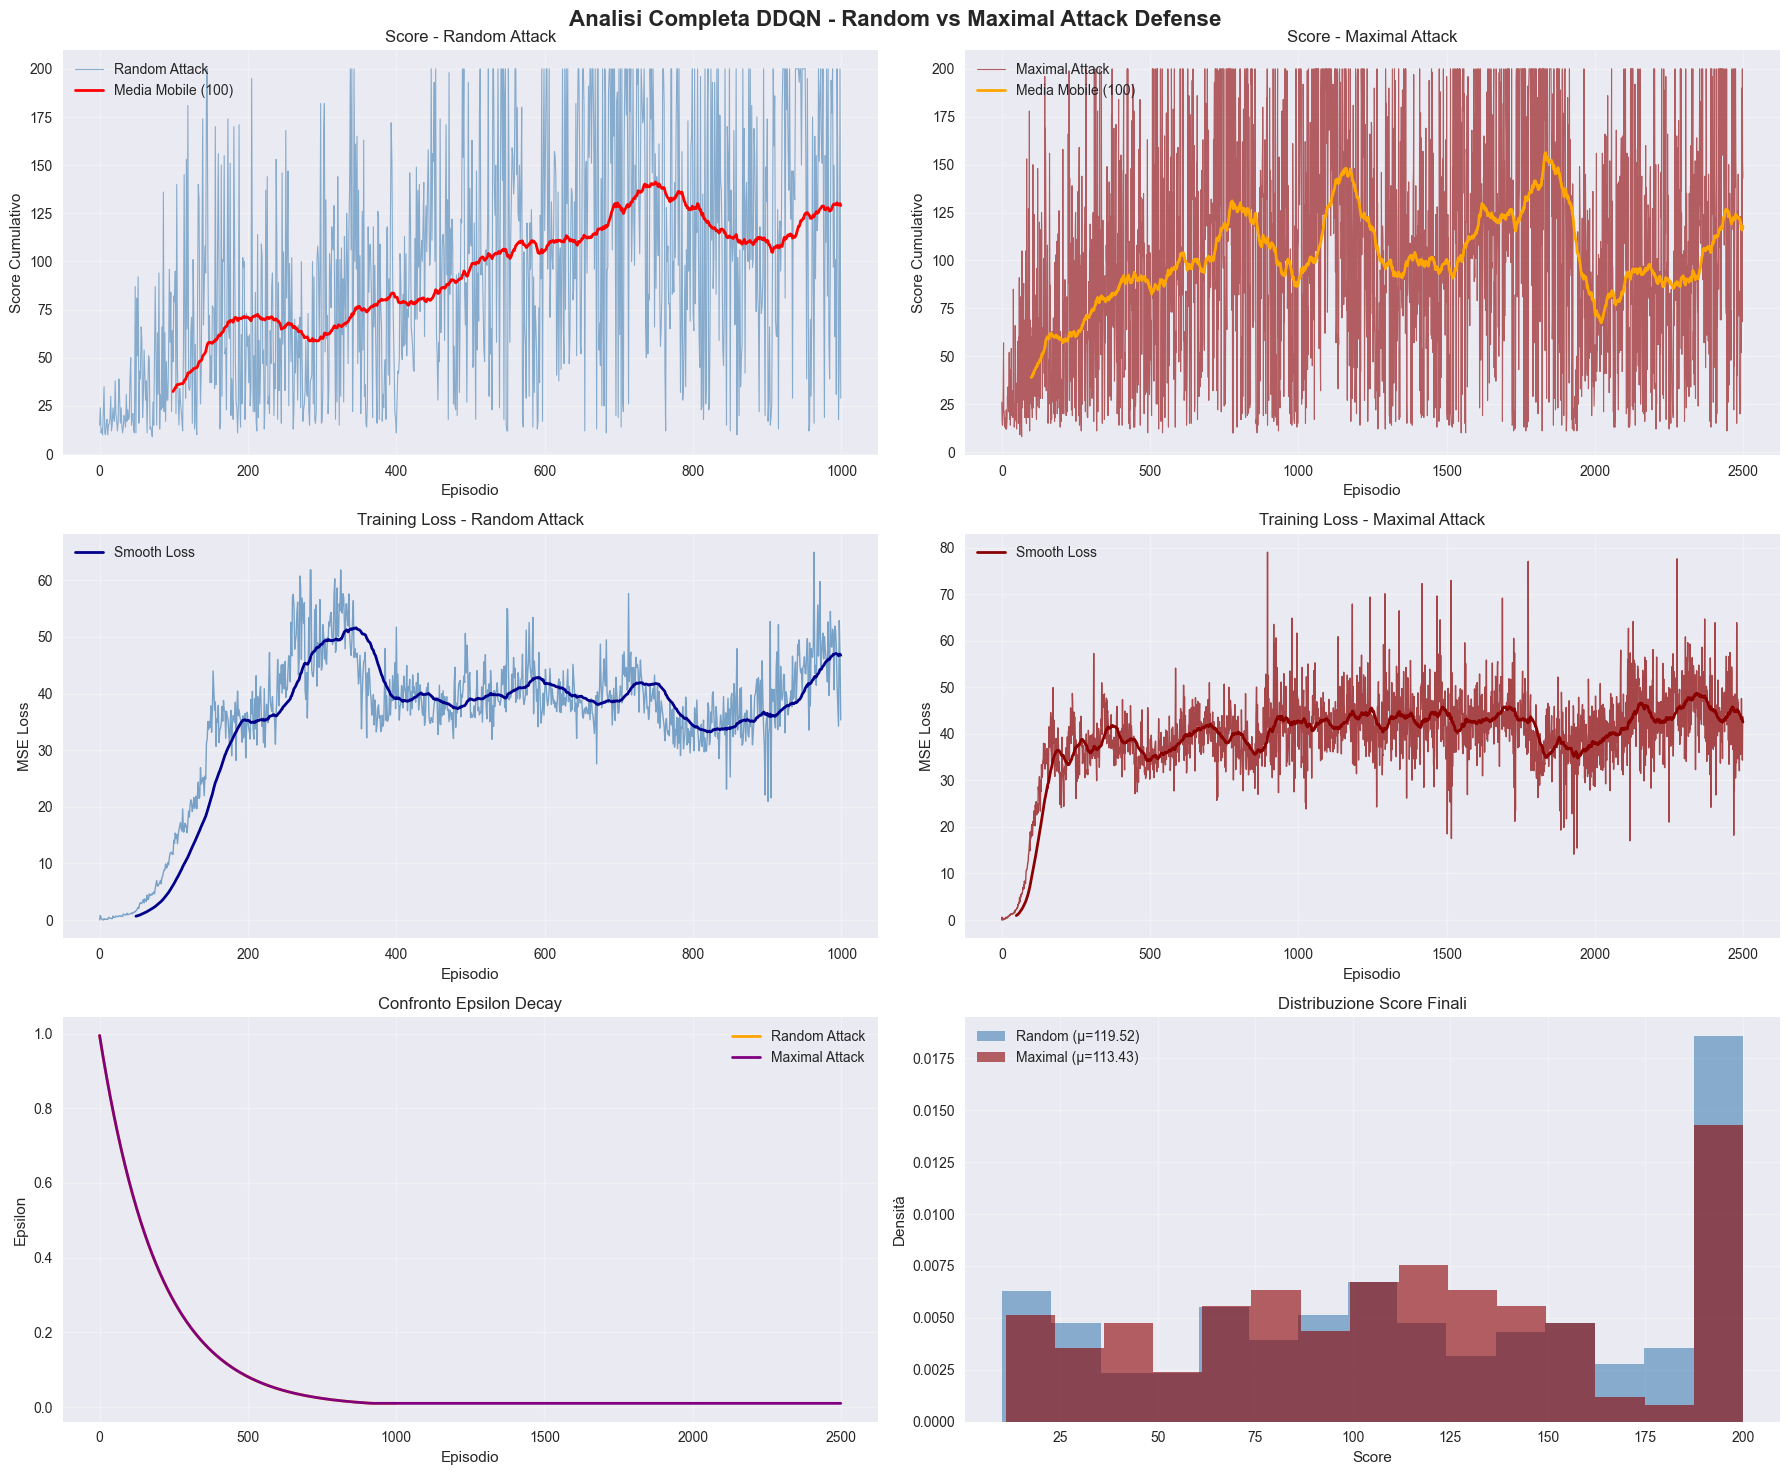


ANALISI STATISTICA COMPLETA - DDQN

RANDOM ATTACK:
   Score medio totale: 94.353
   Score medio ultimi 100: 129.030
   Score massimo: 200.000
   Score minimo: 9.000
   Deviazione standard: 60.812
   Miglioramento: 64.512
   Coefficiente variazione: 0.521
   Stabilità: INSTABILE

MAXIMAL ATTACK:
   Score medio totale: 100.554
   Score medio ultimi 100: 117.910
   Score massimo: 200.000
   Score minimo: 8.000
   Deviazione standard: 59.354
   Miglioramento: 21.688
   Coefficiente variazione: 0.495
   Stabilità: MODERATO



In [13]:
def plot_ddqn_comprehensive_results(scores_random, losses_random, epsilons_random,
                                   scores_maximal, losses_maximal, epsilons_maximal):
    fig, axes = plt.subplots(3, 2, figsize=(18, 15))
    fig.suptitle('Analisi Completa DDQN - Random vs Maximal Attack Defense', 
                 fontsize=16, fontweight='bold')
    
    color_random = 'steelblue'
    color_maximal = 'darkred'
    
    axes[0, 0].plot(scores_random, alpha=0.6, color=color_random, linewidth=0.8, label='Random Attack')
    axes[0, 1].plot(scores_maximal, alpha=0.6, color=color_maximal, linewidth=0.8, label='Maximal Attack')
    
    window = 100
    if len(scores_random) >= window:
        ma_random = pd.Series(scores_random).rolling(window=window).mean()
        axes[0, 0].plot(ma_random, color='red', linewidth=2, label=f'Media Mobile ({window})')
        
    if len(scores_maximal) >= window:
        ma_maximal = pd.Series(scores_maximal).rolling(window=window).mean()
        axes[0, 1].plot(ma_maximal, color='orange', linewidth=2, label=f'Media Mobile ({window})')
    
    axes[0, 0].set_title('Score - Random Attack')
    axes[0, 0].set_xlabel('Episodio')
    axes[0, 0].set_ylabel('Score Cumulativo')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].set_title('Score - Maximal Attack')
    axes[0, 1].set_xlabel('Episodio')
    axes[0, 1].set_ylabel('Score Cumulativo')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[1, 0].plot(losses_random, alpha=0.7, color=color_random, linewidth=1)
    if len(losses_random) >= 50:
        smooth_loss_random = pd.Series(losses_random).rolling(window=50).mean()
        axes[1, 0].plot(smooth_loss_random, color='darkblue', linewidth=2, label='Smooth Loss')
        axes[1, 0].legend()
    
    axes[1, 1].plot(losses_maximal, alpha=0.7, color=color_maximal, linewidth=1)
    if len(losses_maximal) >= 50:
        smooth_loss_maximal = pd.Series(losses_maximal).rolling(window=50).mean()
        axes[1, 1].plot(smooth_loss_maximal, color='darkred', linewidth=2, label='Smooth Loss')
        axes[1, 1].legend()
    
    axes[1, 0].set_title('Training Loss - Random Attack')
    axes[1, 0].set_xlabel('Episodio')
    axes[1, 0].set_ylabel('MSE Loss')
    axes[1, 0].grid(True, alpha=0.3)
    
    axes[1, 1].set_title('Training Loss - Maximal Attack')
    axes[1, 1].set_xlabel('Episodio')
    axes[1, 1].set_ylabel('MSE Loss')
    axes[1, 1].grid(True, alpha=0.3)
    
    axes[2, 0].plot(epsilons_random, color='orange', linewidth=2, label='Random Attack')
    axes[2, 0].plot(epsilons_maximal, color='purple', linewidth=2, label='Maximal Attack')
    axes[2, 0].set_title('Confronto Epsilon Decay')
    axes[2, 0].set_xlabel('Episodio')
    axes[2, 0].set_ylabel('Epsilon')
    axes[2, 0].legend()
    axes[2, 0].grid(True, alpha=0.3)
    
    final_random = scores_random[-200:] if len(scores_random) >= 200 else scores_random
    final_maximal = scores_maximal[-200:] if len(scores_maximal) >= 200 else scores_maximal
    
    axes[2, 1].hist(final_random, bins=15, alpha=0.6, color=color_random, 
                   label=f'Random (μ={np.mean(final_random):.2f})', density=True)
    axes[2, 1].hist(final_maximal, bins=15, alpha=0.6, color=color_maximal, 
                   label=f'Maximal (μ={np.mean(final_maximal):.2f})', density=True)
    axes[2, 1].set_title('Distribuzione Score Finali')
    axes[2, 1].set_xlabel('Score')
    axes[2, 1].set_ylabel('Densità')
    axes[2, 1].legend()
    axes[2, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_ddqn_comprehensive_results(
    ddqn_scores_random, ddqn_losses_random, ddqn_epsilons_random,
    ddqn_scores_maximal, ddqn_losses_maximal, ddqn_epsilons_maximal
)

print("\n" + "="*70)
print("ANALISI STATISTICA COMPLETA - DDQN")
print("="*70)

def analyze_performance(scores, scenario_name):
    """Analizza le prestazioni per uno scenario"""
    print(f"\n{scenario_name.upper()}:")
    print(f"   Score medio totale: {np.mean(scores):.3f}")
    print(f"   Score medio ultimi 100: {np.mean(scores[-100:]):.3f}")
    print(f"   Score massimo: {np.max(scores):.3f}")
    print(f"   Score minimo: {np.min(scores):.3f}")
    print(f"   Deviazione standard: {np.std(scores):.3f}")
    
    first_quarter = scores[:len(scores)//4]
    last_quarter = scores[3*len(scores)//4:]
    improvement = np.mean(last_quarter) - np.mean(first_quarter)
    print(f"   Miglioramento: {improvement:.3f}")
    
    if len(scores) >= 200:
        recent = scores[-200:]
        cv = np.std(recent) / np.mean(recent)
        print(f"   Coefficiente variazione: {cv:.3f}")
        
        if cv < 0.3:
            stability = "STABILE"
        elif cv < 0.5:
            stability = "MODERATO"
        else:
            stability = "INSTABILE"
        print(f"   Stabilità: {stability}")

analyze_performance(ddqn_scores_random, "Random Attack")
analyze_performance(ddqn_scores_maximal, "Maximal Attack")

print("\n" + "="*70)

In [14]:
def test_ddqn_agents(agent_random, agent_maximal, env_random, env_maximal, episodes=100):
    print("TEST FINALE AGENTI DDQN")
    print("="*50)
    
    results = {}
    
    print("\nTesting agente Random Attack...")
    test_scores_random = []
    for episode in range(episodes):
        state = env_random.reset()
        if isinstance(state, tuple):
            state = state[0]
        
        total_reward = 0
        for step in range(200):
            action = agent_random.get_action(state, training=False)
            result = env_random.step(action)
            
            if len(result) == 4:
                next_state, reward, done, info = result
            else:
                next_state, reward, done, truncated, info = result
                done = done or truncated
            
            total_reward += reward
            state = next_state
            
            if done:
                break
        
        test_scores_random.append(total_reward)
    
    print("Testing agente Maximal Attack...")
    test_scores_maximal = []
    for episode in range(episodes):
        state = env_maximal.reset()
        if isinstance(state, tuple):
            state = state[0]
        
        total_reward = 0
        for step in range(200):
            action = agent_maximal.get_action(state, training=False)
            result = env_maximal.step(action)
            
            if len(result) == 4:
                next_state, reward, done, info = result
            else:
                next_state, reward, done, truncated, info = result
                done = done or truncated
            
            total_reward += reward
            state = next_state
            
            if done:
                break
        
        test_scores_maximal.append(total_reward)
    
    results['random'] = test_scores_random
    results['maximal'] = test_scores_maximal
    
    print(f"\nRISULTATI TEST:")
    print(f"Random Attack Defense - Score medio: {np.mean(test_scores_random):.3f}")
    print(f"Maximal Attack Defense - Score medio: {np.mean(test_scores_maximal):.3f}")
    
    return results

test_results = test_ddqn_agents(
    ddqn_agent_random, ddqn_agent_maximal, 
    env_random, env_maximal, episodes=50
)

TEST FINALE AGENTI DDQN

Testing agente Random Attack...
Testing agente Maximal Attack...
Testing agente Maximal Attack...

RISULTATI TEST:
Random Attack Defense - Score medio: 54.020
Maximal Attack Defense - Score medio: 150.800

RISULTATI TEST:
Random Attack Defense - Score medio: 54.020
Maximal Attack Defense - Score medio: 150.800


ANALISI COMPARATIVA COMPLETA

TABELLA COMPARATIVA PRESTAZIONI:
                       score_medio_finale  score_massimo  stabilita  convergenza  miglioramento  tasso_successo
SARSA (Random Attack)                9.43           65.0      0.094       1500.0         -10.86           100.0
DDQN (Random Attack)               129.03          200.0      0.521       1000.0          96.57           100.0
DDQN (Maximal Attack)              117.91          200.0      0.495       2500.0          79.03           100.0

ANALISI DETTAGLIATA:
Metrica                   SARSA           DDQN (Random)   DDQN (Maximal) 
---------------------------------------------------------------------------
score_medio_finale        9.430           129.030         117.910        
stabilita                 0.094           0.521           0.495          
miglioramento             -10.860         96.570          79.030         
tasso_successo            100.000         100.000         100.000        


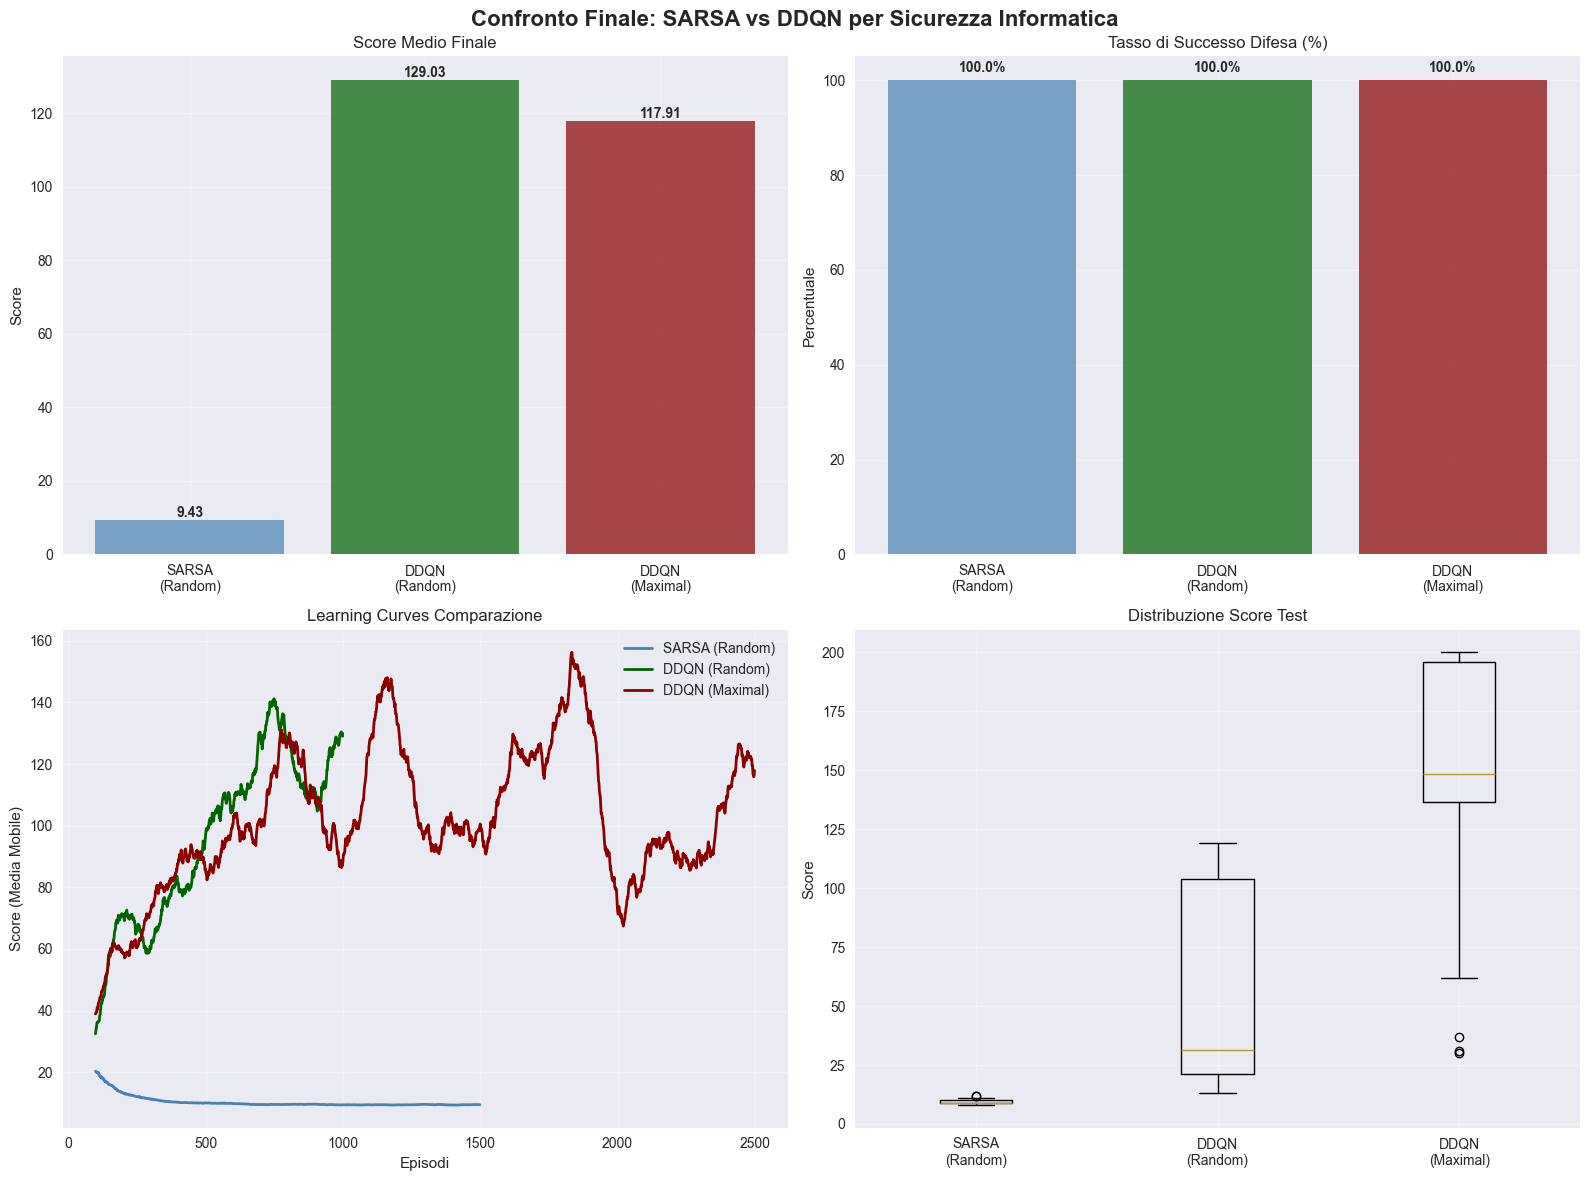


RACCOMANDAZIONI:
Migliore per score finale: DDQN (Random Attack) (129.030)
Migliore per tasso successo: SARSA (100.0%)
Più veloce convergenza: SARSA (episodi di training ridotti)
Più complesso ma versatile: DDQN (gestisce meglio scenari complessi)


In [15]:
def comprehensive_comparison():
    print("ANALISI COMPARATIVA COMPLETA")
    print("="*80)
    
    metrics = {
        'SARSA (Random Attack)': {
            'score_medio_finale': np.mean(sarsa_scores[-100:]),
            'score_massimo': np.max(sarsa_scores),
            'stabilita': np.std(sarsa_scores[-200:]) / np.mean(sarsa_scores[-200:]) if len(sarsa_scores) >= 200 else 0,
            'convergenza': len(sarsa_scores),
            'miglioramento': np.mean(sarsa_scores[-100:]) - np.mean(sarsa_scores[:100]),
            'tasso_successo': len([s for s in test_scores if s > 0]) / len(test_scores) * 100
        },
        'DDQN (Random Attack)': {
            'score_medio_finale': np.mean(ddqn_scores_random[-100:]),
            'score_massimo': np.max(ddqn_scores_random),
            'stabilita': np.std(ddqn_scores_random[-200:]) / np.mean(ddqn_scores_random[-200:]) if len(ddqn_scores_random) >= 200 else 0,
            'convergenza': len(ddqn_scores_random),
            'miglioramento': np.mean(ddqn_scores_random[-100:]) - np.mean(ddqn_scores_random[:100]),
            'tasso_successo': len([s for s in test_results['random'] if s > 0]) / len(test_results['random']) * 100
        },
        'DDQN (Maximal Attack)': {
            'score_medio_finale': np.mean(ddqn_scores_maximal[-100:]),
            'score_massimo': np.max(ddqn_scores_maximal),
            'stabilita': np.std(ddqn_scores_maximal[-200:]) / np.mean(ddqn_scores_maximal[-200:]) if len(ddqn_scores_maximal) >= 200 else 0,
            'convergenza': len(ddqn_scores_maximal),
            'miglioramento': np.mean(ddqn_scores_maximal[-100:]) - np.mean(ddqn_scores_maximal[:100]),
            'tasso_successo': len([s for s in test_results['maximal'] if s > 0]) / len(test_results['maximal']) * 100
        }
    }
    
    df_comparison = pd.DataFrame(metrics).T
    df_comparison = df_comparison.round(3)
    
    print("\nTABELLA COMPARATIVA PRESTAZIONI:")
    print(df_comparison.to_string())
    
    print(f"\nANALISI DETTAGLIATA:")
    print(f"{'Metrica':<25} {'SARSA':<15} {'DDQN (Random)':<15} {'DDQN (Maximal)':<15}")
    print("-" * 75)
    
    for metric in ['score_medio_finale', 'stabilita', 'miglioramento', 'tasso_successo']:
        sarsa_val = metrics['SARSA (Random Attack)'][metric]
        ddqn_random_val = metrics['DDQN (Random Attack)'][metric]
        ddqn_maximal_val = metrics['DDQN (Maximal Attack)'][metric]
        
        print(f"{metric:<25} {sarsa_val:<15.3f} {ddqn_random_val:<15.3f} {ddqn_maximal_val:<15.3f}")
    
    return df_comparison

comparison_df = comprehensive_comparison()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Confronto Finale: SARSA vs DDQN per Sicurezza Informatica', 
             fontsize=16, fontweight='bold')

scores_comparison = [
    np.mean(sarsa_scores[-100:]),
    np.mean(ddqn_scores_random[-100:]),
    np.mean(ddqn_scores_maximal[-100:])
]
labels = ['SARSA\n(Random)', 'DDQN\n(Random)', 'DDQN\n(Maximal)']
colors = ['steelblue', 'darkgreen', 'darkred']

bars = axes[0, 0].bar(labels, scores_comparison, color=colors, alpha=0.7)
axes[0, 0].set_title('Score Medio Finale')
axes[0, 0].set_ylabel('Score')
axes[0, 0].grid(True, alpha=0.3)

for bar, score in zip(bars, scores_comparison):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{score:.2f}', ha='center', va='bottom', fontweight='bold')

success_rates = [
    len([s for s in test_scores if s > 0]) / len(test_scores) * 100,
    len([s for s in test_results['random'] if s > 0]) / len(test_results['random']) * 100,
    len([s for s in test_results['maximal'] if s > 0]) / len(test_results['maximal']) * 100
]

bars2 = axes[0, 1].bar(labels, success_rates, color=colors, alpha=0.7)
axes[0, 1].set_title('Tasso di Successo Difesa (%)')
axes[0, 1].set_ylabel('Percentuale')
axes[0, 1].grid(True, alpha=0.3)

for bar, rate in zip(bars2, success_rates):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                   f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')

window = 100
sarsa_smooth = pd.Series(sarsa_scores).rolling(window=window).mean()
ddqn_random_smooth = pd.Series(ddqn_scores_random).rolling(window=window).mean()
ddqn_maximal_smooth = pd.Series(ddqn_scores_maximal).rolling(window=window).mean()

axes[1, 0].plot(sarsa_smooth, color='steelblue', linewidth=2, label='SARSA (Random)')
axes[1, 0].plot(ddqn_random_smooth, color='darkgreen', linewidth=2, label='DDQN (Random)')
axes[1, 0].plot(ddqn_maximal_smooth, color='darkred', linewidth=2, label='DDQN (Maximal)')

axes[1, 0].set_title('Learning Curves Comparazione')
axes[1, 0].set_xlabel('Episodi')
axes[1, 0].set_ylabel('Score (Media Mobile)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

test_data = [test_scores, test_results['random'], test_results['maximal']]
axes[1, 1].boxplot(test_data, labels=labels)
axes[1, 1].set_title('Distribuzione Score Test')
axes[1, 1].set_ylabel('Score')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nRACCOMANDAZIONI:")
print("="*60)

best_score = max(scores_comparison)
best_success = max(success_rates)

if best_score == scores_comparison[0]:
    best_algo_score = "SARSA"
elif best_score == scores_comparison[1]:
    best_algo_score = "DDQN (Random Attack)"
else:
    best_algo_score = "DDQN (Maximal Attack)"

if best_success == success_rates[0]:
    best_algo_success = "SARSA"
elif best_success == success_rates[1]:
    best_algo_success = "DDQN (Random Attack)"
else:
    best_algo_success = "DDQN (Maximal Attack)"

print(f"Migliore per score finale: {best_algo_score} ({best_score:.3f})")
print(f"Migliore per tasso successo: {best_algo_success} ({best_success:.1f}%)")
print(f"Più veloce convergenza: SARSA (episodi di training ridotti)")
print(f"Più complesso ma versatile: DDQN (gestisce meglio scenari complessi)")
print("="*60)